In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import nest_asyncio
nest_asyncio.apply()
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow import reshape, nest, config
from tensorflow.keras.datasets import mnist
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
from sklearn import preprocessing
from uuid import uuid4
import pickle
np.random.seed(0)

# Set up data

In [3]:
datapath = '/ssd003/projects/pets/application_train.csv'
raw_train = pd.read_csv(datapath)
raw_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing Function

In [4]:
def data_preprocessing(df):
    target = 'TARGET'
    id_col = 'SK_ID_CURR'

    #Delete target column as it is not useful for prediction
    del df[id_col]

    #Distribution of target variable
    df[target].value_counts()

    #Store target variable to be used later
    target_val = df[target]

    #Delete target column from features
    target_col = df.pop(target)

    # Write UID
    uid_col = pd.Series([uuid4() for _ in range(len(df))])

    # Get all continuous variabels 
    cont_vars = []
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            cont_vars.append(col)

    #Store number of continous variable. This will be equivalent to number of neurons in input layer
    cont_train = df.loc[:, cont_vars]
    curr_dim = cont_train.shape[1]
    
    #Fill NAs with mean value of column. Lot of scope of improvement here :)
    cont_train = cont_train.fillna(cont_train.mean())

    #Normalize features using standard scaler. We will use same standard scaler object to normalize test data
    std_scale = preprocessing.StandardScaler().fit(cont_train[cont_vars])
    cont_train[cont_vars] = std_scale.transform(cont_train[cont_vars])
    
    # Extract home credit subdataset
    home_credit_cols = [col for col in cont_train.columns if "credit_bureau" not in str.lower(col)]
    home_credit_df = cont_train[home_credit_cols].copy()
    home_credit_df["target"] = target_col
    return home_credit_df

# Set up partitions

In [5]:
sizes = np.cumsum([10000, 10000, 10000, 10000])
dfs = np.array_split(raw_train.sample(frac=1), sizes)
print([len(d) for d in dfs])

[10000, 10000, 10000, 10000, 267511]


In [6]:
data1 = data_preprocessing(dfs[0])
data1['hospital_id'] = 1

data2 = data_preprocessing(dfs[1])
data2['hospital_id'] = 2

data3 = data_preprocessing(dfs[2])
data3['hospital_id'] = 3

data4 = data_preprocessing(dfs[3])
data4['hospital_id'] = 4

# Combine and format DataFrame

In [7]:
data = pd.concat([data1, data2, data3, data4])

In [8]:
df = data
new = df.copy()
del new['target']
data['features']= new.values.tolist()

#data['hospital_id'] = np.random.randint(1,5, size=len(data))
data = data[['target', 'hospital_id', 'features']]
data.index = range(len(data))

In [9]:
data.head()

,target,hospital_id,features
0,1,1,"[-0.584111265595419, -0.534641392940022, -0.44..."
1,0,1,"[-0.584111265595419, 2.886398100181307, 0.1068..."
2,0,1,"[-0.584111265595419, 2.886398100181307, 0.7541..."
3,0,1,"[0.7886531658861768, 1.9617928317701372, 1.314..."
4,0,1,"[-0.584111265595419, 5.197911271209232, 0.5932..."


In [10]:
data.shape

(40000, 3)

In [11]:
data.hospital_id.value_counts()

4    10000
3    10000
2    10000
1    10000
Name: hospital_id, dtype: int64

# Number of features

In [12]:
n_features = len(data['features'][0])
n_features

99

# Set up the sets of ids

In [13]:
client_id_colname = 'hospital_id' #column that represents client ID 
number_of_training_clients = 3

# split client_id into train and test clients
#client_ids = data[client_id_colname].unique()
#train_client_ids = sample(client_ids.tolist(), number_of_training_clients)
#test_client_ids = [x for x in client_ids if x not in train_client_ids]

train_client_ids = [1,2,3]
test_client_ids = [4]

# Create some TF datasets

In [52]:
SHUFFLE_BUFFER = 1000
NUM_EPOCHS = 10

def create_tf_dataset_for_client_fn(client_id):
    client_data = data[data[client_id_colname] == client_id]
    dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
    dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
    return dataset

In [53]:
if tff.__version__ < "0.19.0":

    train_data = tff.simulation.ClientData.from_clients_and_fn(
        client_ids=train_client_ids,   
        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)
    
    test_data = tff.simulation.ClientData.from_clients_and_fn(
        client_ids=test_client_ids,
        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)
else:
    train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=train_client_ids, 
        serializable_dataset_fn=create_tf_dataset_for_client_fn)
    
    test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=test_client_ids,
        serializable_dataset_fn=create_tf_dataset_for_client_fn)

# Batch preprocessing function

In [66]:
NUM_EPOCHS = 10
BATCH_SIZE = 5000
PREFETCH_BUFFER = 2500
def preprocess(dataset):
    def batch_format_fn(element):    
        return collections.OrderedDict(x=tf.reshape(element['features'], [-1,n_features]),
                                       y=tf.reshape(element['target'], [-1,1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [17]:
example_dataset = train_data.create_tf_dataset_for_client(
        train_data.client_ids[2]
    )
print(example_dataset)
example_element = iter(example_dataset).next()
print(example_element)

<RepeatDataset element_spec={'target': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'hospital_id': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'features': TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)}>
{'target': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, 'hospital_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>, 'features': <tf.Tensor: shape=(1, 99), dtype=float32, numpy=
array([[ 7.8559160e-01, -3.3936617e-01, -8.1249046e-01, -9.4385183e-01,
        -7.2301924e-01, -1.8810077e-01,  8.4947109e-01, -4.5928642e-01,
         9.8134279e-01,  1.6657898e-01,  0.0000000e+00,  0.0000000e+00,
         4.6327537e-01, -5.2101421e-01,  4.8013564e-02,  1.6051598e+00,
        -2.4078444e-01,  9.1497576e-01,  1.8880671e+00,  1.9576063e+00,
         6.0451549e-01, -1.3346049e-01, -2.3821698e-01, -2.1042186e-01,
        -3.0635363e-01, -5.4992956e-01, -4.6375299e-01,  3.3379120e-01,
         4.5627856e-01,  1.0018573e+0

In [18]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[-0.5747402 ,  2.2362227 , -0.9248106 , ..., -0.02450225,
                      -0.03001351,  3.        ],
                     [-0.5747402 ,  0.12892272,  0.1283029 , ..., -0.02450225,
                      -0.03001351,  3.        ],
                     [ 0.7855916 , -0.24570838, -0.81249046, ..., -0.02450225,
                      -0.03001351,  3.        ],
                     ...,
                     [-0.5747402 ,  2.470367  ,  1.204779  , ..., -0.02450225,
                      -0.03001351,  3.        ],
                     [-0.5747402 , -0.10522173, -0.5582426 , ..., -0.02450225,
                      -0.03001351,  3.        ],
                     [ 0.7855916 , -0.10522173, -1.2321185 , ..., -0.02450225,
                      -0.03001351,  3.        ]], dtype=float32)),
             ('y',
              array([[0],
                     [0],
                     [0],
                     ...,
                     [0],
                    

In [19]:
sample_batch['x'].shape

(5000, 99)

# Federated data preprocessing

In [20]:
def make_federated_data(client_data, client_ids):
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

# Client datasets

In [21]:
%%time
#train_client_ids = sample(client_ids.tolist(), number_of_training_clients)
federated_train_data = make_federated_data(train_data, train_data.client_ids)
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 3
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>
CPU times: user 8.26 s, sys: 50.8 ms, total: 8.31 s
Wall time: 8.31 s


# Keras model

In [22]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(n_features,)), # n_features
      tf.keras.layers.Dense(150, activation = 'swish'),
        tf.keras.layers.Dense(50, activation = 'swish'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
      ])

In [23]:
import tensorflow_addons as tfa

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(name='Precision'),
               tf.keras.metrics.Recall(name='Recall'), tf.keras.metrics.AUC(name='AUC')])

/ssd003/projects/aieng/public/pets_unified/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.8.0-dev20211102). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


# TensorFlow Federated simulation process

In [24]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01)) 

In [25]:
iterative_process.initialize.type_signature

FunctionType(None, FederatedType(StructType([('model', StructType([('trainable', StructType([TensorType(tf.float32, [99, 150]), TensorType(tf.float32, [150]), TensorType(tf.float32, [150, 50]), TensorType(tf.float32, [50]), TensorType(tf.float32, [50, 1]), TensorType(tf.float32, [1])]) as list), ('non_trainable', StructType([]) as list)]) as ModelWeights), ('optimizer_state', StructType([TensorType(tf.int64)]) as list), ('delta_aggregate_state', StructType([('value_sum_process', StructType([]) as tuple), ('weight_sum_process', StructType([]) as tuple)]) as OrderedDict), ('model_broadcast_state', StructType([]) as tuple)]) as ServerState, PlacementLiteral('server'), True))

In [26]:
str(iterative_process.next.type_signature)

'(<server_state=<model=<trainable=<float32[99,150],float32[150],float32[150,50],float32[50],float32[50,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER,federated_dataset={<x=float32[?,99],y=int32[?,1]>*}@CLIENTS> -> <<model=<trainable=<float32[99,150],float32[150],float32[150,50],float32[50],float32[50,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER,<broadcast=<>,aggregation=<mean_value=<>,mean_weight=<>>,train=<binary_accuracy=float32,Precision=float32,Recall=float32,AUC=float32,loss=float32>,stat=<num_examples=int64>>@SERVER>)'

# Training Loop

In [67]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
federated_test_data = make_federated_data(test_data, test_client_ids)

In [68]:
def training_loop(federated_train_data, federated_test_data, iterative_process, NUM_ROUNDS):
    loss = list()
    accuracy = list()
    val_loss = list()
    val_accuracy = list()
    precision = list()
    recall = list()
    f1 = list()
    val_precision = list()
    val_recall = list()
    val_f1 = list() 
    train_AUC = list()
    val_AUC = list() 

    state = iterative_process.initialize()

    for round_num in range(1, NUM_ROUNDS+1):
        state, metrics = iterative_process.next(state, federated_train_data)
        val_metrics = evaluation(state.model, federated_test_data)

        my_precision = metrics['train']['Precision']
        precision.append(my_precision)

        my_recall = metrics['train']['Recall']
        recall.append(my_recall)

        my_f1 = 2 * (my_precision * my_recall) / (my_precision + my_recall)
        f1.append(my_f1)

        val_precision.append(val_metrics['eval']['Precision'])
        val_recall.append(val_metrics['eval']['Recall'])
        my_val_f1 = 2 * (val_metrics['eval']['Precision'] * val_metrics['eval']['Recall']) / (val_metrics['eval']['Precision'] + val_metrics['eval']['Recall'])
        val_f1.append(my_val_f1)

        my_loss = metrics['train']['loss']

        train_AUC.append(metrics['train']['AUC'])
        val_AUC.append(val_metrics['eval']['AUC'])

        loss.append(metrics['train']['loss'])
        accuracy.append(metrics['train']['binary_accuracy'])
        my_acc = val_metrics['eval']['binary_accuracy']
        val_loss.append(val_metrics['eval']['loss'])
        val_accuracy.append(val_metrics['eval']['binary_accuracy'])
        print(f"round: {round_num:2d}, loss: {my_loss}, test_accuracy: {val_accuracy}, training_recall : {my_recall}, training_precision = {my_precision}, training_f1 = {my_f1}, val_precision = {val_metrics['eval']['Precision']}, val_recall = {val_metrics['eval']['Recall']}, val_f1 = {my_val_f1}")

    return {
        'state':state,
        'accuracy': accuracy,
        'val_accuracy': val_accuracy,
        'loss': loss,
        'val_loss': val_loss,
        'precision': precision,
        'val_precision': precision,
        'recall': recall,
        'val_recall': val_recall,
    }

### Three clients

In [75]:
%%time
train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=[1,2,3], 
        serializable_dataset_fn=create_tf_dataset_for_client_fn)

federated_train_data = make_federated_data(train_data, [1,2,3])

iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01))

results = training_loop(federated_train_data, federated_test_data, iterative_process, 50)

round:  1, loss: 0.4130234718322754, test_accuracy: [0.2339], training_recall : 0.04485318809747696, training_precision = 0.07481598854064941, training_f1 = 0.05608354255224766, val_precision = 0.07956356555223465, val_recall = 0.809226930141449, val_f1 = 0.14488224804730332
round:  2, loss: 0.4110648036003113, test_accuracy: [0.2339, 0.2499], training_recall : 0.04255872592329979, training_precision = 0.07493021339178085, training_f1 = 0.05428484638119441, val_precision = 0.0792613998055458, val_recall = 0.7867830395698547, val_f1 = 0.14401460032354163
round:  3, loss: 0.4091384708881378, test_accuracy: [0.2339, 0.2499, 0.2687], training_recall : 0.04026006534695625, training_precision = 0.07488725334405899, training_f1 = 0.05236710013036716, val_precision = 0.07933841645717621, val_recall = 0.7655860185623169, val_f1 = 0.14377707139370235
round:  4, loss: 0.4072470963001251, test_accuracy: [0.2339, 0.2499, 0.2687, 0.2891], training_recall : 0.0381082221865654, training_precision = 0.

round: 24, loss: 0.3751710057258606, test_accuracy: [0.2339, 0.2499, 0.2687, 0.2891, 0.3086, 0.3305, 0.3566, 0.3804, 0.4062, 0.4356, 0.4605, 0.4838, 0.5102, 0.5347, 0.5579, 0.5825, 0.6031, 0.6289, 0.6523, 0.6723, 0.6933, 0.7139, 0.7328, 0.75], training_recall : 0.009639261290431023, training_precision = 0.07671251147985458, training_f1 = 0.017126502995399716, val_precision = 0.07676968723535538, val_recall = 0.19201995432376862, val_f1 = 0.10968660315171697
round: 25, loss: 0.373817503452301, test_accuracy: [0.2339, 0.2499, 0.2687, 0.2891, 0.3086, 0.3305, 0.3566, 0.3804, 0.4062, 0.4356, 0.4605, 0.4838, 0.5102, 0.5347, 0.5579, 0.5825, 0.6031, 0.6289, 0.6523, 0.6723, 0.6933, 0.7139, 0.7328, 0.75, 0.7654], training_recall : 0.008926174603402615, training_precision = 0.07707631587982178, training_f1 = 0.015999459339591005, val_precision = 0.07488986849784851, val_recall = 0.16957606375217438, val_f1 = 0.10389610864576138
round: 26, loss: 0.37248846888542175, test_accuracy: [0.2339, 0.2499,

round: 40, loss: 0.35585591197013855, test_accuracy: [0.2339, 0.2499, 0.2687, 0.2891, 0.3086, 0.3305, 0.3566, 0.3804, 0.4062, 0.4356, 0.4605, 0.4838, 0.5102, 0.5347, 0.5579, 0.5825, 0.6031, 0.6289, 0.6523, 0.6723, 0.6933, 0.7139, 0.7328, 0.75, 0.7654, 0.7794, 0.7939, 0.8074, 0.8193, 0.8292, 0.8373, 0.8465, 0.8551, 0.8629, 0.8686, 0.8741, 0.8794, 0.8836, 0.8871, 0.8899], training_recall : 0.002671979833394289, training_precision = 0.07675623893737793, training_f1 = 0.005164188052703042, val_precision = 0.07648725062608719, val_recall = 0.03366583585739136, val_f1 = 0.046753247675588826
round: 41, loss: 0.35479626059532166, test_accuracy: [0.2339, 0.2499, 0.2687, 0.2891, 0.3086, 0.3305, 0.3566, 0.3804, 0.4062, 0.4356, 0.4605, 0.4838, 0.5102, 0.5347, 0.5579, 0.5825, 0.6031, 0.6289, 0.6523, 0.6723, 0.6933, 0.7139, 0.7328, 0.75, 0.7654, 0.7794, 0.7939, 0.8074, 0.8193, 0.8292, 0.8373, 0.8465, 0.8551, 0.8629, 0.8686, 0.8741, 0.8794, 0.8836, 0.8871, 0.8899, 0.8917], training_recall : 0.0024580

In [76]:
train_metrics = evaluation(results['state'].model, federated_train_data)
train_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.8996),
                           ('Precision', 0.082446806),
                           ('Recall', 0.026006712),
                           ('AUC', 0.5118891),
                           ('loss', 0.5016577)])),
             ('stat', OrderedDict([('num_examples', 3000000)]))])

In [77]:
test_metrics = evaluation(results['state'].model, federated_test_data)
test_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.9064),
                           ('Precision', 0.059210528),
                           ('Recall', 0.011221945),
                           ('AUC', 0.51601064),
                           ('loss', 0.46452308)])),
             ('stat', OrderedDict([('num_examples', 1000000)]))])

Text(0.5, 0, 'Round')

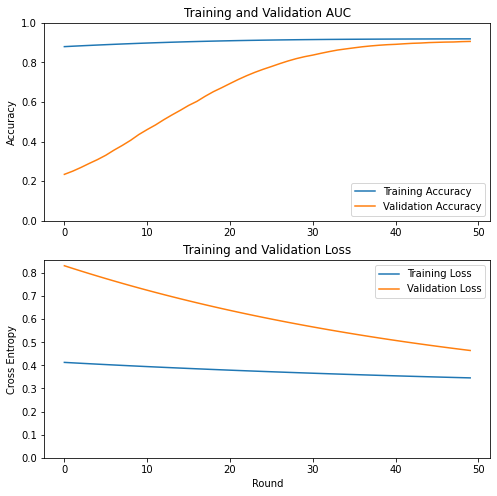

In [78]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.plot(results['accuracy'], label='Training Accuracy')
ax1.plot(results['val_accuracy'], label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation AUC')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.plot(results['loss'], label='Training Loss')
ax2.plot(results['val_loss'], label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Round')

# plt.savefig('./figures/DELIRIUM_normalized_TFF_accuracy_loss_10_rounds.png')

Text(0.5, 0, 'Round')

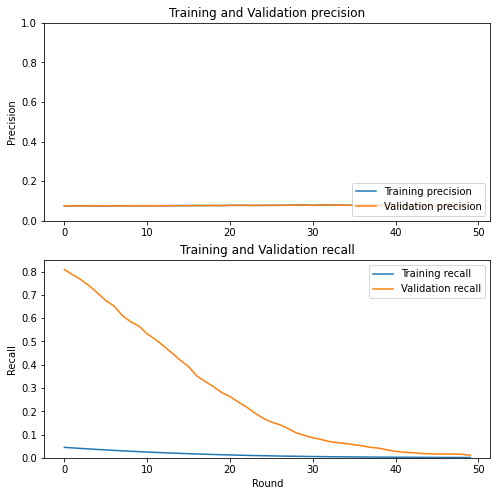

In [79]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.plot(results['precision'], label='Training precision')
ax1.plot(results['val_precision'], label='Validation precision')
ax1.legend(loc='lower right')
ax1.set_ylabel('Precision')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation precision')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.plot(results['recall'], label='Training recall')
ax2.plot(results['val_recall'], label='Validation recall')
ax2.legend(loc='upper right')
ax2.set_ylabel('Recall')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation recall')
ax2.set_xlabel('Round')

In [81]:
results['val_recall']

[0.80922693,
 0.78678304,
 0.765586,
 0.7394015,
 0.7082294,
 0.67581046,
 0.6521197,
 0.6109726,
 0.584788,
 0.5660848,
 0.53241897,
 0.5087282,
 0.48004988,
 0.45012468,
 0.4189526,
 0.3915212,
 0.35162094,
 0.32793018,
 0.3054863,
 0.28054863,
 0.26309228,
 0.23940149,
 0.21820448,
 0.19201995,
 0.16957606,
 0.15336658,
 0.14214464,
 0.12593517,
 0.10723192,
 0.09600998,
 0.08603492,
 0.07855362,
 0.06982543,
 0.0648379,
 0.061097257,
 0.056109726,
 0.051122196,
 0.04488778,
 0.04114713,
 0.033665836,
 0.027431421,
 0.023690773,
 0.02244389,
 0.018703243,
 0.017456358,
 0.016209476,
 0.016209476,
 0.016209476,
 0.014962593,
 0.011221945]

In [80]:
results['val_precision']

[0.07481599,
 0.07493021,
 0.07488725,
 0.0749056,
 0.07473213,
 0.074855015,
 0.074808456,
 0.07496859,
 0.07500529,
 0.07516418,
 0.075191215,
 0.075094886,
 0.07531058,
 0.07570082,
 0.07578474,
 0.07582528,
 0.07614253,
 0.0759919,
 0.076443024,
 0.076046735,
 0.07696756,
 0.07706756,
 0.07693732,
 0.07671251,
 0.077076316,
 0.077258445,
 0.07721546,
 0.07741428,
 0.07825868,
 0.078426,
 0.07724203,
 0.078297764,
 0.07818068,
 0.07794374,
 0.07772574,
 0.07742678,
 0.07683464,
 0.07733609,
 0.07743658,
 0.07675624,
 0.076103896,
 0.07615848,
 0.07703882,
 0.07565737,
 0.075069346,
 0.07610322,
 0.07492969,
 0.07412168,
 0.07470602,
 0.072578646]

# Individual model(s)

In [82]:
%%time
train_data1 = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=[1], 
        serializable_dataset_fn=create_tf_dataset_for_client_fn)

federated_train_data1 = make_federated_data(train_data1, [1])

iterative_process1 = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01))

results1 = training_loop(federated_train_data1, federated_test_data, iterative_process1, 50)

round:  1, loss: 0.4406229555606842, test_accuracy: [0.5972], training_recall : 0.04606727138161659, training_precision = 0.07560349255800247, training_f1 = 0.05725034221506501, val_precision = 0.08125648647546768, val_recall = 0.390274316072464, val_f1 = 0.13450794744111155
round:  2, loss: 0.43840131163597107, test_accuracy: [0.5972, 0.6163], training_recall : 0.044036220759153366, training_precision = 0.0763622522354126, training_f1 = 0.055859593764948534, val_precision = 0.07975629717111588, val_recall = 0.3591022491455078, val_f1 = 0.13052344925510584
round:  3, loss: 0.43621402978897095, test_accuracy: [0.5972, 0.6163, 0.6328], training_recall : 0.04137128219008446, training_precision = 0.0758700892329216, training_f1 = 0.05354497002707826, val_precision = 0.07917888462543488, val_recall = 0.3366583585739136, val_f1 = 0.1282051291239518
round:  4, loss: 0.43406394124031067, test_accuracy: [0.5972, 0.6163, 0.6328, 0.6522], training_recall : 0.039404917508363724, training_precision

round: 24, loss: 0.3973742723464966, test_accuracy: [0.5972, 0.6163, 0.6328, 0.6522, 0.6685, 0.6873, 0.7047, 0.7198, 0.7308, 0.7425, 0.7556, 0.7669, 0.7776, 0.788, 0.7953, 0.8041, 0.8121, 0.8181, 0.8227, 0.8271, 0.8335, 0.8392, 0.8443, 0.8486], training_recall : 0.012341526336967945, training_precision = 0.07427014410495758, training_f1 = 0.02116589801332012, val_precision = 0.0690072625875473, val_recall = 0.07107231765985489, val_f1 = 0.07002456736189312
round: 25, loss: 0.3958137333393097, test_accuracy: [0.5972, 0.6163, 0.6328, 0.6522, 0.6685, 0.6873, 0.7047, 0.7198, 0.7308, 0.7425, 0.7556, 0.7669, 0.7776, 0.788, 0.7953, 0.8041, 0.8121, 0.8181, 0.8227, 0.8271, 0.8335, 0.8392, 0.8443, 0.8486, 0.8522], training_recall : 0.011720568872988224, training_precision = 0.07422579079866409, training_f1 = 0.02024445273405415, val_precision = 0.0677749365568161, val_recall = 0.06608478724956512, val_f1 = 0.06691919248141025
round: 26, loss: 0.3942762017250061, test_accuracy: [0.5972, 0.6163, 0

round: 40, loss: 0.37487930059432983, test_accuracy: [0.5972, 0.6163, 0.6328, 0.6522, 0.6685, 0.6873, 0.7047, 0.7198, 0.7308, 0.7425, 0.7556, 0.7669, 0.7776, 0.788, 0.7953, 0.8041, 0.8121, 0.8181, 0.8227, 0.8271, 0.8335, 0.8392, 0.8443, 0.8486, 0.8522, 0.8567, 0.8594, 0.8622, 0.866, 0.8689, 0.872, 0.8746, 0.8773, 0.8795, 0.882, 0.8837, 0.8863, 0.8877, 0.889, 0.8908], training_recall : 0.005381629802286625, training_precision = 0.07423269003629684, training_f1 = 0.01003570365563995, val_precision = 0.04968944191932678, val_recall = 0.019950125366449356, val_f1 = 0.028469752662497284
round: 41, loss: 0.373636394739151, test_accuracy: [0.5972, 0.6163, 0.6328, 0.6522, 0.6685, 0.6873, 0.7047, 0.7198, 0.7308, 0.7425, 0.7556, 0.7669, 0.7776, 0.788, 0.7953, 0.8041, 0.8121, 0.8181, 0.8227, 0.8271, 0.8335, 0.8392, 0.8443, 0.8486, 0.8522, 0.8567, 0.8594, 0.8622, 0.866, 0.8689, 0.872, 0.8746, 0.8773, 0.8795, 0.882, 0.8837, 0.8863, 0.8877, 0.889, 0.8908, 0.8932], training_recall : 0.005187580827623

Text(0.5, 0, 'Round')

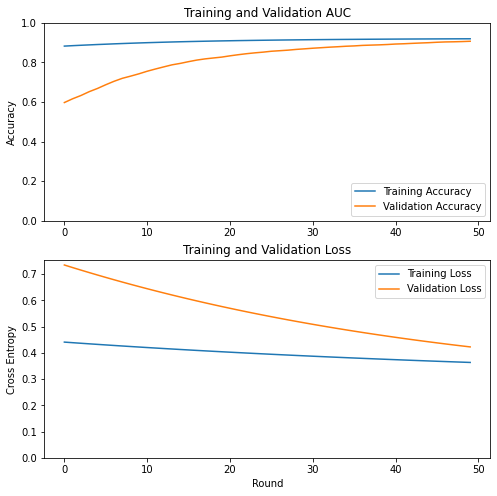

In [83]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.plot(results1['accuracy'], label='Training Accuracy')
ax1.plot(results1['val_accuracy'], label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation AUC')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.plot(results1['loss'], label='Training Loss')
ax2.plot(results1['val_loss'], label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Round')

# plt.savefig('./figures/DELIRIUM_normalized_TFF_accuracy_loss_10_rounds.png')

Text(0.5, 0, 'Round')

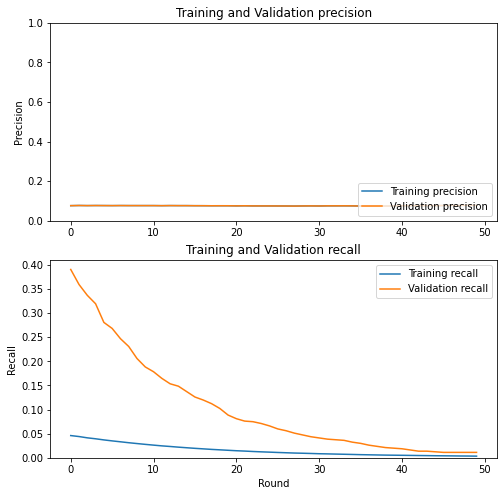

In [84]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.plot(results1['precision'], label='Training precision')
ax1.plot(results1['val_precision'], label='Validation precision')
ax1.legend(loc='lower right')
ax1.set_ylabel('Precision')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation precision')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.plot(results1['recall'], label='Training recall')
ax2.plot(results1['val_recall'], label='Validation recall')
ax2.legend(loc='upper right')
ax2.set_ylabel('Recall')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation recall')
ax2.set_xlabel('Round')